In [1]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import transforms, models
# import matplotlib.pyplot as plt
# import numpy as np
from fastai.vision.all import *

In [47]:
import os
from dotenv import load_dotenv
load_dotenv() 
# Path to dataset
path = Path(os.getenv("DATASET_PATH"))

# DataLoaders with built-in augmentation
dls = ImageDataLoaders.from_folder(
    path,
    valid_pct=0.2,       # 80/20 split
    seed=42,             # reproducibility
    bs=32,               # batch size
    item_tfms=Resize(460, method=ResizeMethod.Squish, pad_mode='zeros'),  # resize before augmentation
    batch_tfms=[
        *aug_transforms(  # fastai's smart augmentations
            size= 224,
            do_flip=True,
            flip_vert=False,
            max_rotate=10,
            max_zoom=1.1,
            min_scale=0.9,
            max_warp=0.05,
            p_affine=0.5,
            p_lighting=0.7
            
        ),
        Normalize.from_stats(*imagenet_stats)
    ]
)

In [62]:
learn = vision_learner(
    dls,
    resnet34,
    metrics=accuracy,
    loss_func=CrossEntropyLossFlat(),
    opt_func=SGD
)


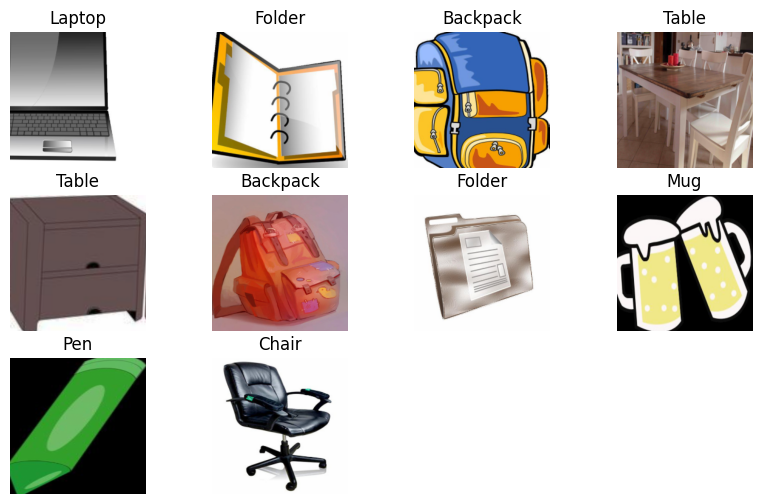

In [61]:
dls.show_batch(max_n=10, figsize=(10,6))

In [63]:
# print classes
print(dls.vocab)

['Backpack', 'Chair', 'File_Cabinet', 'Folder', 'Laptop', 'Mug', 'Notebook', 'Pen', 'Table', 'Trash_Can']


SuggestedLRs(valley=0.015848932787775993)

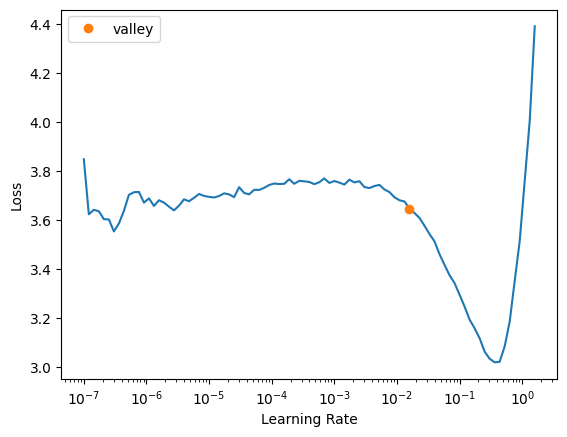

In [64]:
# Find learning rate
learn.lr_find()

Take the learning rate before the loss sharply increases so, taking learning rate of 2e-2

In [65]:
# freeze petrained layers
learn.freeze()

# train head for r epoch with learning rate of 2e-2
learn.fit_one_cycle(5, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.313422,0.690991,0.784906,04:19
1,1.119041,0.346159,0.896226,05:58
2,0.707327,0.302823,0.896226,04:23
3,0.532176,0.279802,0.901887,04:27
4,0.427369,0.280534,0.909434,04:32


SuggestedLRs(valley=0.0010000000474974513)

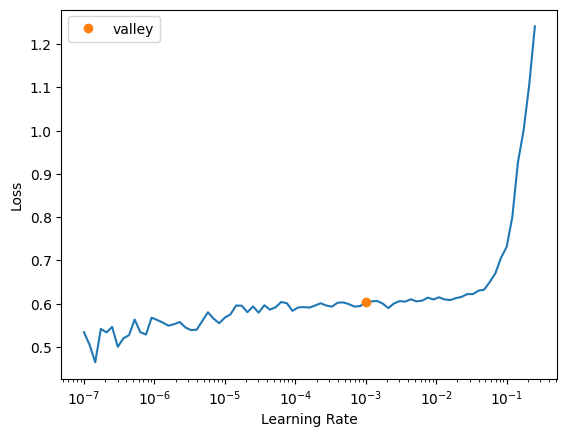

In [14]:
#unfreeze model and find learning rate
learn.unfreeze()
learn.lr_find()


The learning rate range is (1e-5, 1e-3)

In [16]:
#fine tune the entire model
learn.fit_one_cycle(10, lr_max=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.600492,0.461927,0.854717,09:03
1,0.600225,0.474384,0.849057,07:54
2,0.626146,0.460170,0.847170,06:31
3,0.568970,0.446312,0.858491,06:40
4,0.543348,0.455889,0.852830,07:00
5,0.569700,0.439853,0.856604,06:41
6,0.566775,0.447219,0.854717,05:58
7,0.549497,0.451335,0.854717,11:52
8,0.548732,0.447204,0.862264,07:27
9,0.560588,0.443504,0.854717,06:29
